#  Brain Tumor Segmentation (BraTS 2020) with U-Net

## 1. Project Overview
This project focuses on **Automated Medical Image Segmentation** using the BraTS 2020 dataset. The goal is to develop a Deep Learning model that can precisely identify and delineate different sub-regions of brain tumors from multi-modal MRI scans.

### Why this matters?
Manual segmentation by radiologists is time-consuming and prone to human error. Automating this process helps in:
* **Treatment Planning:** Determining the exact volume for surgical resection or radiation.
* **Progression Monitoring:** Tracking how a tumor responds to therapy over time.

---

## 2. The Dataset (BraTS 2020)
We are utilizing the **Multimodal Brain Tumor Segmentation Challenge (BraTS) 2020** dataset.

### MRI Modalities:
For every patient, the dataset provides four distinct 3D MRI sequences:
1.  **FLAIR (Fluid Attenuated Inversion Recovery):** Excellent for identifying peritumoral edema (swelling).
2.  **T1-weighted:** Standard anatomical view.
3.  **T1ce (T1-contrast enhanced):** Highlights the "active" tumor core using a contrast agent (Gadolinium).
4.  **T2-weighted:** Useful for identifying different tissue contrasts.

### The Segmentation Labels:
The ground truth masks contain 4 distinct pixel values:
* **Label 0:** Background (Healthy tissue).
* **Label 1:** Necrotic and Non-Enhancing Tumor Core (NCR/NET).
* **Label 2:** Peritumoral Edema (ED).
* **Label 4:** Enhancing Tumor (ET).

---

## 3. Project Roadmap
Our pipeline follows a "Step-by-Step" complexity progression:
1.  **Data Exploration:** Visualizing 3D volumes as 2D axial slices.
2.  **2.D Approach:** Slicing the 3D volumes into 2D images for a standard U-Net.
3.  **3D Approach:** Utilizing volumetric data to capture spatial context between slices.
4.  **Evaluation:** Using the **Dice Coefficient** to measure the overlap between our AI's prediction and the expert's manual segmentation.

In [1]:
!pip install nibabel

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brats20-dataset-training-validation' dataset.
Path to dataset files: /kaggle/input/brats20-dataset-training-validation


In [3]:
import os

# 1. Use the 'path' variable returned by kagglehub.dataset_download
# The BraTS 2020 dataset usually has a specific nested structure:
# path -> BraTS2020_TrainingData -> MICCAI_BraTS2020_TrainingData
data_dir = os.path.join(path, "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")
data_dir
# 2. Check if the directory exists
if os.path.exists(data_dir):
    print(f"✅ Success! Data found at: {data_dir}")
    # List first 3 folders to verify
    print("Sample patient folders:", os.listdir(data_dir)[:3])
else:
    print("❌ Directory not found. Let's find the correct subfolder...")
    # This helps you find where the patient folders (BraTS20_Training_xxx) actually are
    for root, dirs, files in os.walk(path):
        if "BraTS20_Training_001" in dirs:
            data_dir = root
            print(f"🎯 Found it! Update your data_dir to: {data_dir}")
            break

✅ Success! Data found at: /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
Sample patient folders: ['BraTS20_Training_083', 'BraTS20_Training_337', 'BraTS20_Training_161']


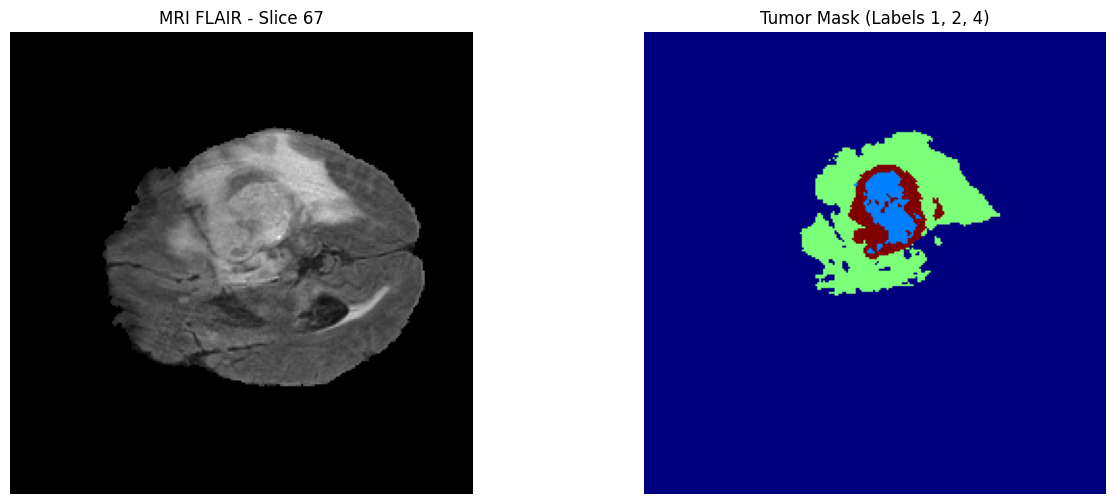

 Successfully displayed slice 67 from /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii


In [4]:
actual_base_path = path
data_dir = None

for root, dirs, files in os.walk(actual_base_path):
    if "BraTS20_Training_001" in dirs:
        data_dir = root
        break

if data_dir:
    patient_id = "BraTS20_Training_001"
    patient_path = os.path.join(data_dir, patient_id)

    #  Check for .nii or .nii.gz automatically
    def get_nii_path(p_path, p_id, suffix):
        full_path = os.path.join(p_path, f"{p_id}_{suffix}.nii.gz")
        if not os.path.exists(full_path):
            full_path = os.path.join(p_path, f"{p_id}_{suffix}.nii")
        return full_path

    flair_path = get_nii_path(patient_path, patient_id, "flair")
    seg_path = get_nii_path(patient_path, patient_id, "seg")

    #  Load and Plot
    flair_vol = nib.load(flair_path).get_fdata()
    seg_vol = nib.load(seg_path).get_fdata()

    # Find a slice that actually has a tumor so we don't see a blank brain
    # We look for the slice with the maximum amount of tumor pixels
    tumor_counts = [np.sum(seg_vol[:, :, i] > 0) for i in range(seg_vol.shape[2])]
    best_slice = np.argmax(tumor_counts)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(flair_vol[:, :, best_slice], cmap='gray')
    plt.title(f"MRI FLAIR - Slice {best_slice}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    # We use 'jet' or 'gnuplot' to make the different tumor labels pop
    plt.imshow(seg_vol[:, :, best_slice], cmap='jet')
    plt.title("Tumor Mask (Labels 1, 2, 4)")
    plt.axis('off')

    plt.show()
    print(f" Successfully displayed slice {best_slice} from {flair_path}")
else:
    print(" Could not locate the BraTS20_Training_001 folder in the download path.")

##  Understanding the BraTS 2020 Segmentation Labels

Medical segmentation isn't just about finding the "tumor"; it's about identifying the different types of tissue within and around it. The BraTS dataset uses a specific labeling convention that corresponds to different physiological regions:

| Label | Tissue Type | Description |
| :--- | :--- | :--- |
| **0** | **Background** | Healthy brain tissue or area outside the skull. |
| **1** | **Necrotic & Non-Enhancing Core (NCR/NET)** | Dead tissue or tumor parts that do not take up contrast agent. |
| **2** | **Peritumoral Edema (ED)** | Swelling/fluid surrounding the tumor (highly visible in FLAIR). |
| **4** | **Enhancing Tumor (ET)** | The "active" part of the tumor that glows brightly on T1ce scans. |

### Target Regions for Training:
In many research papers (and for our 2D approach), these are often grouped:
1. **Whole Tumor (WT):** Labels 1 + 2 + 4
2. **Tumor Core (TC):** Labels 1 + 4
3. **Enhancing Tumor (ET):** Label 4 only

## Phase 1: Data Exploration:
In this section, we expand our view from a single slice to a **sequence of slices** across the Z-axis (Axial plane).

### Why Visualize in 3D?
Brain tumors are volumetric structures. By looking at a sequence, we can observe the "nesting" behavior of the tumor sub-regions:
* **The Shell:** The **Edema (Green)** often appears first as a protective or reactive layer around the growth.
* **The Core:** As we move toward the center of the mass, the **Enhancing Tumor (Yellow/Red)** and **Necrotic Core (Blue)** become visible.

### Visualization Strategy
We plot the **FLAIR modality** (Row 1) alongside its corresponding **Multi-class Mask** (Row 2). This allows us to visually verify that the high-intensity signals in the MRI align with the expert labels.

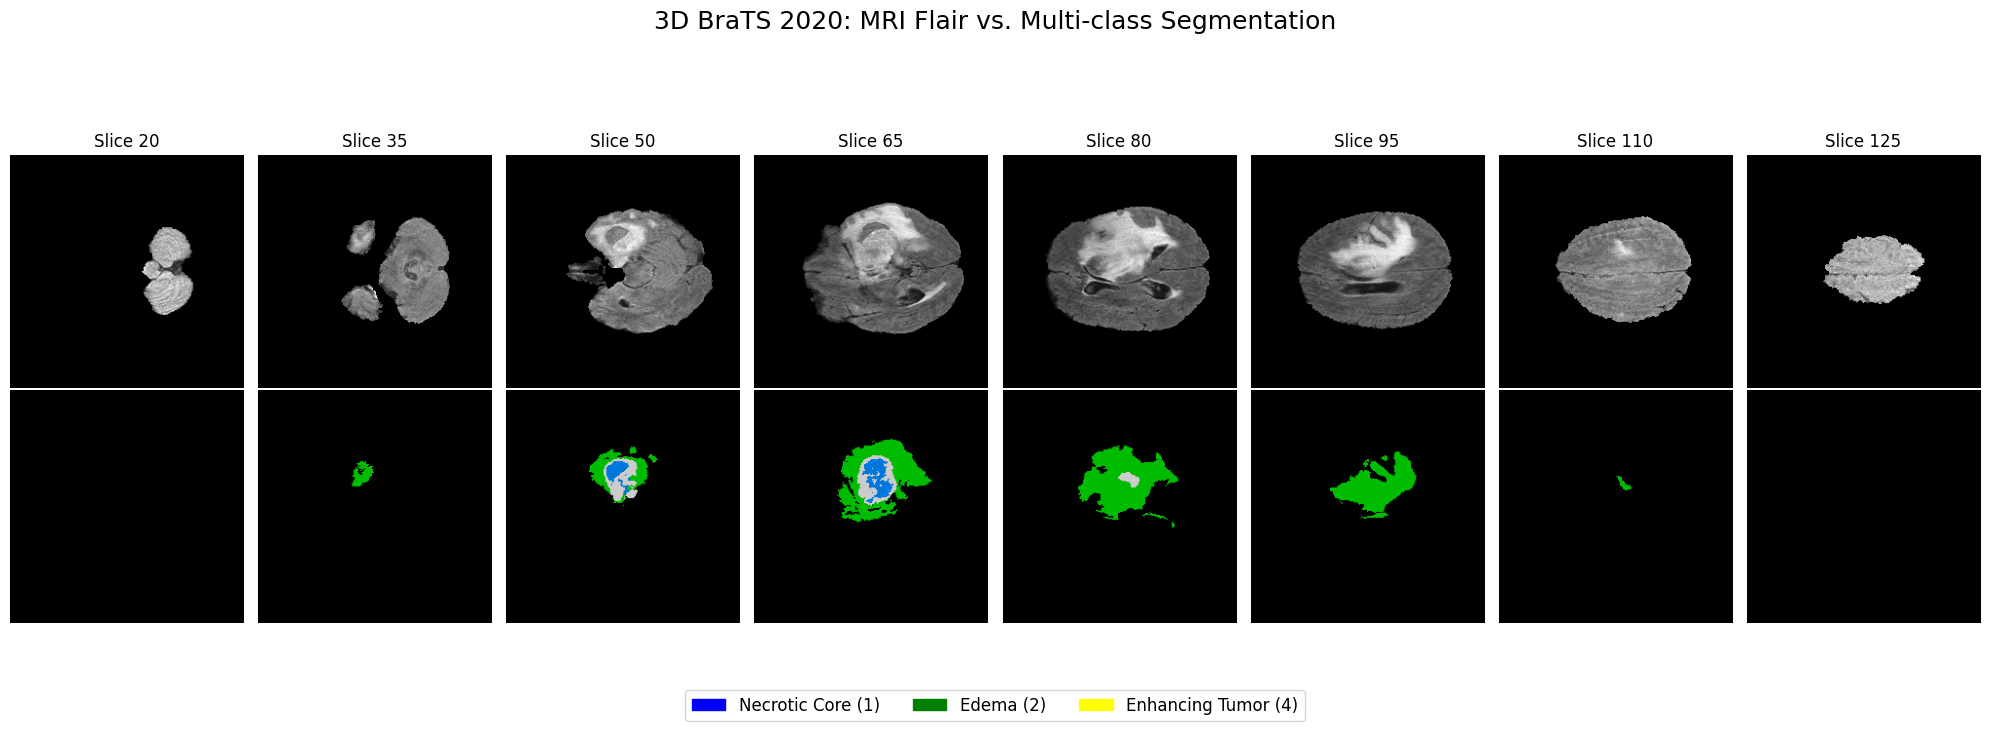

In [5]:
import matplotlib.patches as mpatches

def plot_3d_segmentation_sequence(flair_vol, seg_vol, step=15):
    """
    Plots a sequence of MRI slices and their corresponding multi-label masks.
    """
    slices = range(20, flair_vol.shape[2] - 20, step) # Avoid empty slices at start/end
    n_slices = len(slices)

    # Create the figure with two rows: Row 1 = MRI, Row 2 = Mask
    fig, axes = plt.subplots(2, n_slices, figsize=(20, 8))

    # Define colors for the legend
    # Labels: 1 (NCR-Blue), 2 (ED-Green), 4 (ET-Yellow/Red)
    labels = {
        "Necrotic Core (1)": 'blue',
        "Edema (2)": 'green',
        "Enhancing Tumor (4)": 'yellow'
    }
    patches = [mpatches.Patch(color=v, label=k) for k, v in labels.items()]

    for i, s in enumerate(slices):
        # Row 1: Flair MRI
        axes[0, i].imshow(flair_vol[:, :, s], cmap='gray')
        axes[0, i].set_title(f"Slice {s}")
        axes[0, i].axis('off')

        # Row 2: Segmentation Mask
        # We use 'nipy_spectral' or 'viridis' to distinguish discrete labels
        axes[1, i].imshow(seg_vol[:, :, s], cmap='nipy_spectral', vmin=0, vmax=4)
        axes[1, i].axis('off')

    # Add legend to the figure
    fig.legend(handles=patches, loc='lower center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, 0.05))
    plt.suptitle("3D BraTS 2020: MRI Flair vs. Multi-class Segmentation", fontsize=18, y=0.95)
    plt.tight_layout(rect=[0, 0.1, 1, 0.9])
    plt.show()

# Call the function using the volumes loaded previously
plot_3d_segmentation_sequence(flair_vol, seg_vol)

### 🛠️ Data Engineering: Class Mapping & Preprocessing
To train our first 2D U-Net, we need to simplify the labels. While the dataset provides multi-class information, we will focus on **Whole Tumor (WT)** segmentation.

### Preprocessing Steps:
1. **Label Merging:** We combine labels 1, 2, and 4 into a single binary class (1 = Tumor).
2. **Normalization:** MRI pixel intensities vary wildly between machines. We will use **Min-Max Normalization** to scale the FLAIR intensities between 0 and 1.
3. **Dimensionality Reduction:** We extract 2D slices from the 3D volumes, keeping only those that contain a significant amount of tumor pixels to prevent the model from learning "empty" background slices.

In [6]:
import cv2

def create_2d_training_data(data_dir, img_size=128, max_patients=20):
    x_train = []
    y_train = []

    # Filter for patient folders
    patients = [p for p in os.listdir(data_dir) if p.startswith("BraTS20")]

    print(f" Processing {max_patients} patients into 2D slices...")

    for patient in patients[:max_patients]:
        p_path = os.path.join(data_dir, patient)

        # Extension check (.nii or .nii.gz)
        ext = ".nii.gz" if os.path.exists(os.path.join(p_path, f"{patient}_flair.nii.gz")) else ".nii"

        # Load volumes
        flair = nib.load(os.path.join(p_path, f"{patient}_flair{ext}")).get_fdata()
        seg = nib.load(os.path.join(p_path, f"{patient}_seg{ext}")).get_fdata()

        # Loop through slices
        for i in range(flair.shape[2]):
            slice_f = flair[:, :, i]
            slice_s = seg[:, :, i]

            # Skip slices with almost no tumor (threshold of 50 pixels)
            if np.sum(slice_s > 0) > 50:

                # 1. Resize
                slice_f = cv2.resize(slice_f, (img_size, img_size), interpolation=cv2.INTER_AREA)
                slice_s = cv2.resize(slice_s, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

                # 2. Normalize Intensity
                if np.max(slice_f) > 0:
                    slice_f = (slice_f - np.min(slice_f)) / (np.max(slice_f) - np.min(slice_f) + 1e-8) #This is a "safety epsilon" to prevent a DivisionByZero error if we encounter a completely black slice

                # 3. Class Mapping (Merge 1, 2, 4 into 1)
                binary_mask = np.where(slice_s > 0, 1.0, 0.0)

                x_train.append(slice_f)
                y_train.append(binary_mask)

    # Convert to NumPy arrays and add channel dimension (Batch, H, W, Channel)
    X = np.expand_dims(np.array(x_train), axis=-1)
    Y = np.expand_dims(np.array(y_train), axis=-1)

    print(f" Created {X.shape[0]} training samples of size {img_size}x{img_size}")
    return X.astype(np.float32), Y.astype(np.float32)

# --- EXECUTE ---
X_train, Y_train = create_2d_training_data(data_dir, img_size=128, max_patients=30)

 Processing 30 patients into 2D slices...
 Created 1838 training samples of size 128x128


### From Patients to Slices: Understanding Data Expansion

A common question in medical AI is: *How did 30 patients become 1,838 training samples?* The answer lies in the **Volumetric Nature** of MRI data. Unlike a standard photograph (which is a single 2D plane), an MRI is a **3D volume** composed of many "slices" stacked together, similar to a loaf of sliced bread.

### The Math of Expansion:
1. **The 3D Volume:** Each patient in the BraTS dataset has a volume consisting of **155 slices** along the Z-axis.
2. **The 2D Extraction:** By treating each slice as an independent 2D image, we technically have $30 \text{ patients} \times 155 \text{ slices} = 4,650$ potential images.
3. **Filtering for Quality:** Not every slice contains a tumor. Many slices are at the very top or bottom of the skull. Our preprocessing script filters these out, keeping only slices where the tumor is visible.

### Why do we do this?
* **Data Augmentation:** It naturally increases our dataset size, providing the U-Net with many different "views" of the tumor at different depths.
* **Memory Efficiency:** Training on one 2D slice ($128 \times 128$) is significantly less demanding on the GPU than training on a full 3D volume ($128 \times 128 \times 128$).
* **Focus:** By filtering for tumor-heavy slices, we ensure the model spends its time learning relevant features rather than looking at empty healthy tissue.

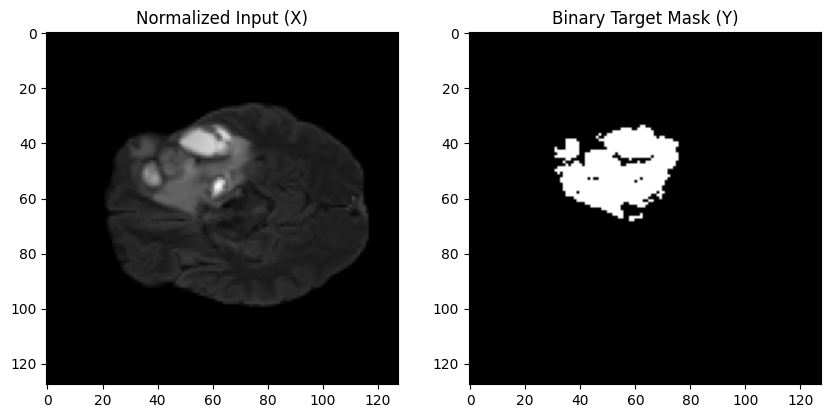

In [7]:
idx = np.random.randint(0, len(X_train))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train[idx].squeeze(), cmap='gray')
plt.title("Normalized Input (X)")

plt.subplot(1, 2, 2)
plt.imshow(Y_train[idx].squeeze(), cmap='gray')
plt.title("Binary Target Mask (Y)")
plt.show()

###  Training vs. Validation Split
To ensure our model generalizes well to new patients, we must split our processed 2D slices into two sets:

1. **Training Set (80-90%):** The data the U-Net sees during training to learn how to identify tumors.
2. **Validation Set (10-20%):** The "unseen" data used during training to monitor performance. If the training loss goes down but validation loss stays high, we know the model is **overfitting**.

Since we are working with slices from the same patients, we typically shuffle the slices to ensure both sets contain a diverse variety of tumor shapes and sizes.

In [8]:
from sklearn.model_selection import train_test_split

# We split 20% of the data for validation
# random_state ensures that if we run this again, we get the same split
X_train_final, X_val, Y_train_final, Y_val = train_test_split(
    X_train,
    Y_train,
    test_size=0.2,
    random_state=42
)

print("📊 Data Split Summary:")
print(f"Training Data:   {X_train_final.shape}")
print(f"Validation Data: {X_val.shape}")

📊 Data Split Summary:
Training Data:   (1470, 128, 128, 1)
Validation Data: (368, 128, 128, 1)


In [9]:
print(f"X_train range: [{X_train_final.min()}, {X_train_final.max()}]")
print(f"Y_train range: [{np.unique(Y_train_final)}]")

X_train range: [0.0, 1.0]
Y_train range: [[0. 1.]]


##  Phase 2: the 2D U-Net
In this phase, we initialize our **U-Net** and begin the training process.

### Key Components:
1.  **Architecture:** A standard U-Net with 5 levels of depth.
2.  **Hybrid Loss Function:** We use a combination of **Binary Cross-Entropy (BCE)** and **Dice Loss**. BCE helps with pixel-level stability, while Dice Loss optimizes for the overlap (crucial for small tumors).
3.  **Metrics:** We monitor the **Dice Coefficient** throughout training, as it is the most meaningful way to measure segmentation success in medical imaging.

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_model(img_width=128, img_height=128):
    # --- Define the architecture parameters ---
    # The number of kernels/feature channels per block
    n_channels = [16, 32, 64, 128, 256]
    k_size = (3, 3)                      # Size of filter kernel
    k_init = 'he_normal'                # Kernel initializer for ReLU
    encoder_list = []

    # Input layer (1 channel because we are using grayscale FLAIR MRI)
    inp = Input(shape=(img_width, img_height, 1))
    x = inp

    # --- Encoder (Contracting Path) ---
    for i, f in enumerate(n_channels):
        # Two convolutions per block to extract features
        x = Conv2D(f, k_size, activation='relu', padding='same', kernel_initializer=k_init)(x)
        x = Conv2D(f, k_size, activation='relu', padding='same', kernel_initializer=k_init)(x)

        # Save output for skip connection (BEFORE pooling)
        encoder_list.append(x)

        # Downsample for all blocks EXCEPT the last one (the bottleneck)
        if i < len(n_channels) - 1:
            x = MaxPooling2D(pool_size=(2, 2))(x)

    # --- Decoder (Expansive Path) ---
    # We loop backward through the channels, starting from the second-to-last
    for i, f in enumerate(n_channels[-2::-1]):
        # 1. Upsample (Transpose Convolution)
        x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(x)

        # 2. Retrieve the corresponding skip connection from the encoder
        # This provides the high-resolution detail needed for precise edges
        skip_connection = encoder_list[len(n_channels) - 2 - i]

        # 3. Concatenate the upsampled features with the skip connection
        x = concatenate([x, skip_connection], axis=-1)

        # 4. Two convolutions to refine the merged features
        x = Conv2D(f, k_size, activation='relu', padding='same', kernel_initializer=k_init)(x)
        x = Conv2D(f, k_size, activation='relu', padding='same', kernel_initializer=k_init)(x)

    # --- Output Layer ---
    # 1x1 Convolution with Sigmoid activation to produce a binary probability mask
    outp = Conv2D(1, (1, 1), activation='sigmoid')(x)

    # Build the Model
    model = Model(inputs=[inp], outputs=[outp], name="U-Net_BraTS")

    return model

In [13]:
import tensorflow as tf
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-5):
    """
    Computes the Dice Coefficient (Overlap Score) for 2D slices.
    Range: [0, 1]. 1.0 = Perfect Overlap.
    """
    # Ensure types are consistent (float32)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Flatten 2D images into 1D vectors for calculation
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    """
    Calculates Dice Loss. The model tries to minimize this.
    """
    return 1 - dice_coef(y_true, y_pred)

def custom_dice_loss(y_true, y_pred):
    """
    Hybrid Loss: 50% Binary Cross-Entropy + 50% Dice Loss.
    """
    # Ensure float32 for math stability
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Standard Binary Cross Entropy
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Combine the two
    return 0.5 * bce + 0.5 * dice_loss(y_true, y_pred)

In [14]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 1. Initialize the Model
# Ensure img_width and img_height match your X_train shape (128)
model = unet_model(img_width=128, img_height=128)

# 2. Compile with our Hybrid Loss and Dice Metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=custom_dice_loss,
    metrics=[dice_coef, 'accuracy']
)

# 3. Define Callbacks for "Smart" Training
callbacks = [
    # Saves the best version of the model based on validation Dice score
    ModelCheckpoint('best_unet_model.keras', verbose=1, save_best_only=True, monitor='val_dice_coef', mode='max'),
    # Stops training if the model stops improving for 5 epochs
    EarlyStopping(patience=8, monitor='val_dice_coef', mode='max', restore_best_weights=True),
    # Reduces the learning rate if the loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]



In [15]:
model.summary()

Model: "U-Net_BraTS"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │        160 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 128, 128,  │      2,320 │ conv2d_38[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_40[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_42[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 16, 16,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_44[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 8, 8, 128) │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 8, 8, 256) │    590,080 │ conv2d_46[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 16, 16,    │    131,200 │ conv2d_47[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

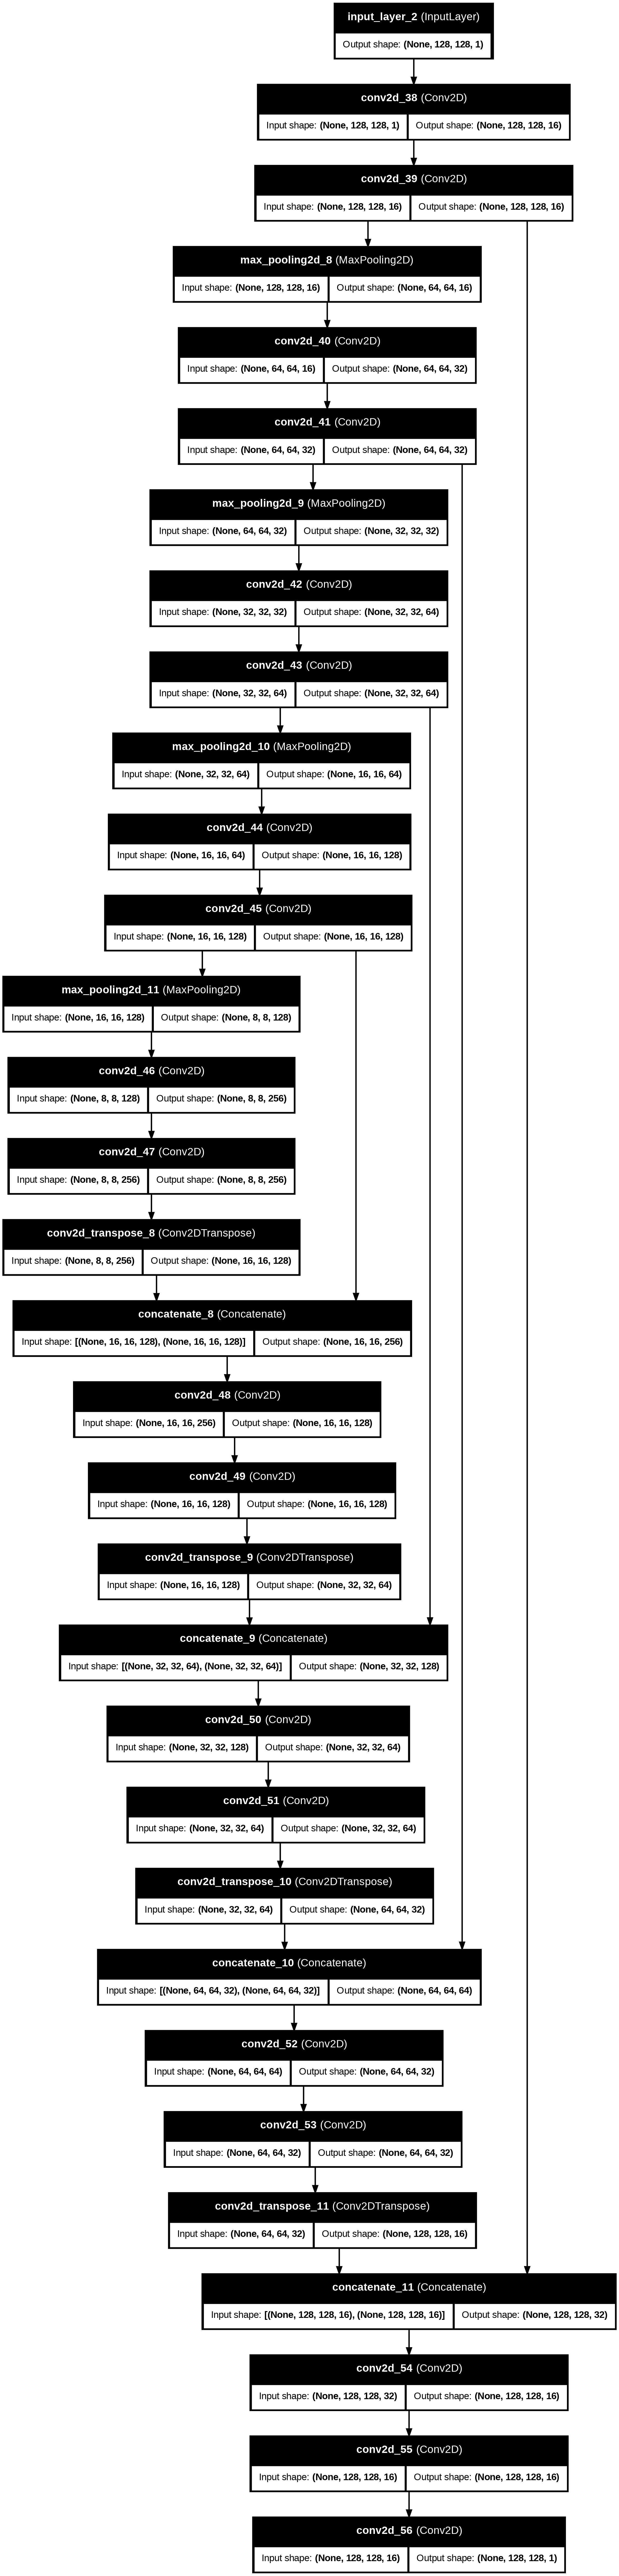

In [16]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Generate the plot
# show_shapes=True is vital for seeing how the image dimensions change
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the image directly in your Colab notebook
Image('model_architecture.png')

###  Architecture Deep-Dive: The U-Net

The model we have built follows the **U-Net** architecture, which is a "Fully Convolutional Network." It is called a U-Net because of its symmetrical shape, which is divided into three main sections.

### 1. The Contracting Path (The Encoder)
The left side of the "U" acts as a feature extractor.
* **Goal:** To capture the **context** of the image (understanding "what" is in the image).
* **Process:** It consists of repeated blocks of two $3 \times 3$ convolutions followed by a $2 \times 2$ Max Pooling layer.
* **Effect:** As we go deeper, the spatial dimensions (Width and Height) decrease, but the number of feature channels increases (from 16 up to 256).

### 2. The Bottleneck
The very bottom of the "U" is the deepest part of the network.
* **Goal:** To provide a high-level, compressed representation of the tumor features.
* **Process:** This layer contains the most filters (256) and acts as the bridge between the encoder and decoder.

### 3. The Expansive Path (The Decoder)
The right side of the "U" is responsible for precise reconstruction.
* **Goal:** To enable **precise localization** (determining exactly "where" the tumor is).
* **Process:** It uses **Transpose Convolutions** (Up-sampling) to gradually restore the image to its original $128 \times 128$ size.
* **Refinement:** After each up-sampling step, the model performs two more $3 \times 3$ convolutions to refine the segmentation boundaries.

### 4. Skip Connections (The "Secret Sauce")
You will notice horizontal lines connecting the Encoder blocks directly to the Decoder blocks.
* **Why they exist:** During the down-sampling in the Encoder, some fine spatial detail (like the exact edges of a tumor) is lost.
* **How they work:** We "skip" high-resolution features from the Encoder and concatenate them with the up-sampled features in the Decoder.
* **Benefit:** This allows the model to combine high-level categorical information ("This is a tumor") with low-level structural detail ("The edge is exactly at these coordinates").

---

### ⚙️ Output Layer
The final layer is a **$1 \times 1$ Convolution** with a **Sigmoid** activation function.
* **Logic:** This maps the 16 feature channels back to a single channel.
* **Result:** Each pixel in the output is assigned a probability between **0 and 1**. If a pixel's value is $> 0.5$, the AI classifies it as part of the **Whole Tumor**.

In [17]:
print(" Training started... this may take a few minutes per epoch.")
history = model.fit(
    X_train_final,
    Y_train_final,
    validation_data=(X_val, Y_val),
    batch_size=16,
    epochs=25,
    callbacks=callbacks,
    verbose=1
)

🏃 Training started... this may take a few minutes per epoch.
Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8854 - dice_coef: 0.1196 - loss: 0.6335
Epoch 1: val_dice_coef improved from -inf to 0.64859, saving model to best_unet_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 178ms/step - accuracy: 0.8861 - dice_coef: 0.1216 - loss: 0.6315 - val_accuracy: 0.9827 - val_dice_coef: 0.6486 - val_loss: 0.2033 - learning_rate: 1.0000e-04
Epoch 2/25
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9847 - dice_coef: 0.6840 - loss: 0.1835
Epoch 2: val_dice_coef improved from 0.64859 to 0.69462, saving model to best_unet_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9847 - dice_coef: 0.6845 - loss: 0.1832 - val_accuracy: 0.9808 - val_dice_coef: 0.6946 - val_loss: 0.1814 - learning_rate: 1.0000e-04
Epoch 3/25
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9875 - dice_coef: 0.7572 - loss: 0.1419
Epoch 3: val_dice_coef improved from 0.69462 to 0.74145, s

In [30]:
# Evaluate the 2D model on the 2D validation set
results_2d = model.evaluate(X_val, Y_val, verbose=1)

print(f"\n 2D Model Performance:")
print(f"Average Validation Loss: {results_2d[0]:.4f}")
print(f"Average Validation Dice: {results_2d[1]:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9970 - dice_coef: 0.9372 - loss: 0.0366

📊 2D Model Performance:
Average Validation Loss: 0.0356
Average Validation Dice: 0.9394


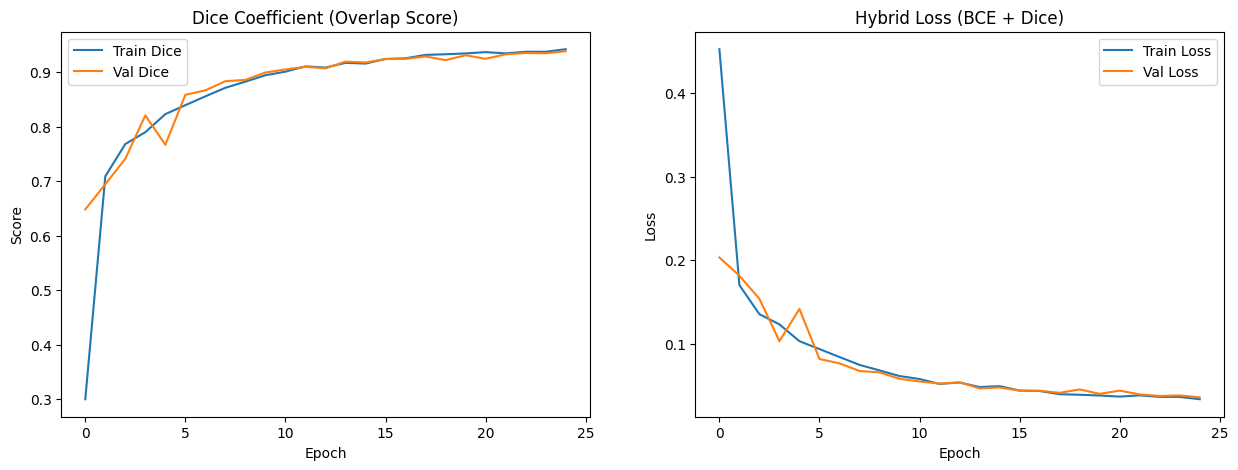

In [18]:
def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    # Plot Dice Coefficient
    plt.subplot(1, 2, 1)
    plt.plot(history.history['dice_coef'], label='Train Dice')
    plt.plot(history.history['val_dice_coef'], label='Val Dice')
    plt.title('Dice Coefficient (Overlap Score)')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Hybrid Loss (BCE + Dice)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


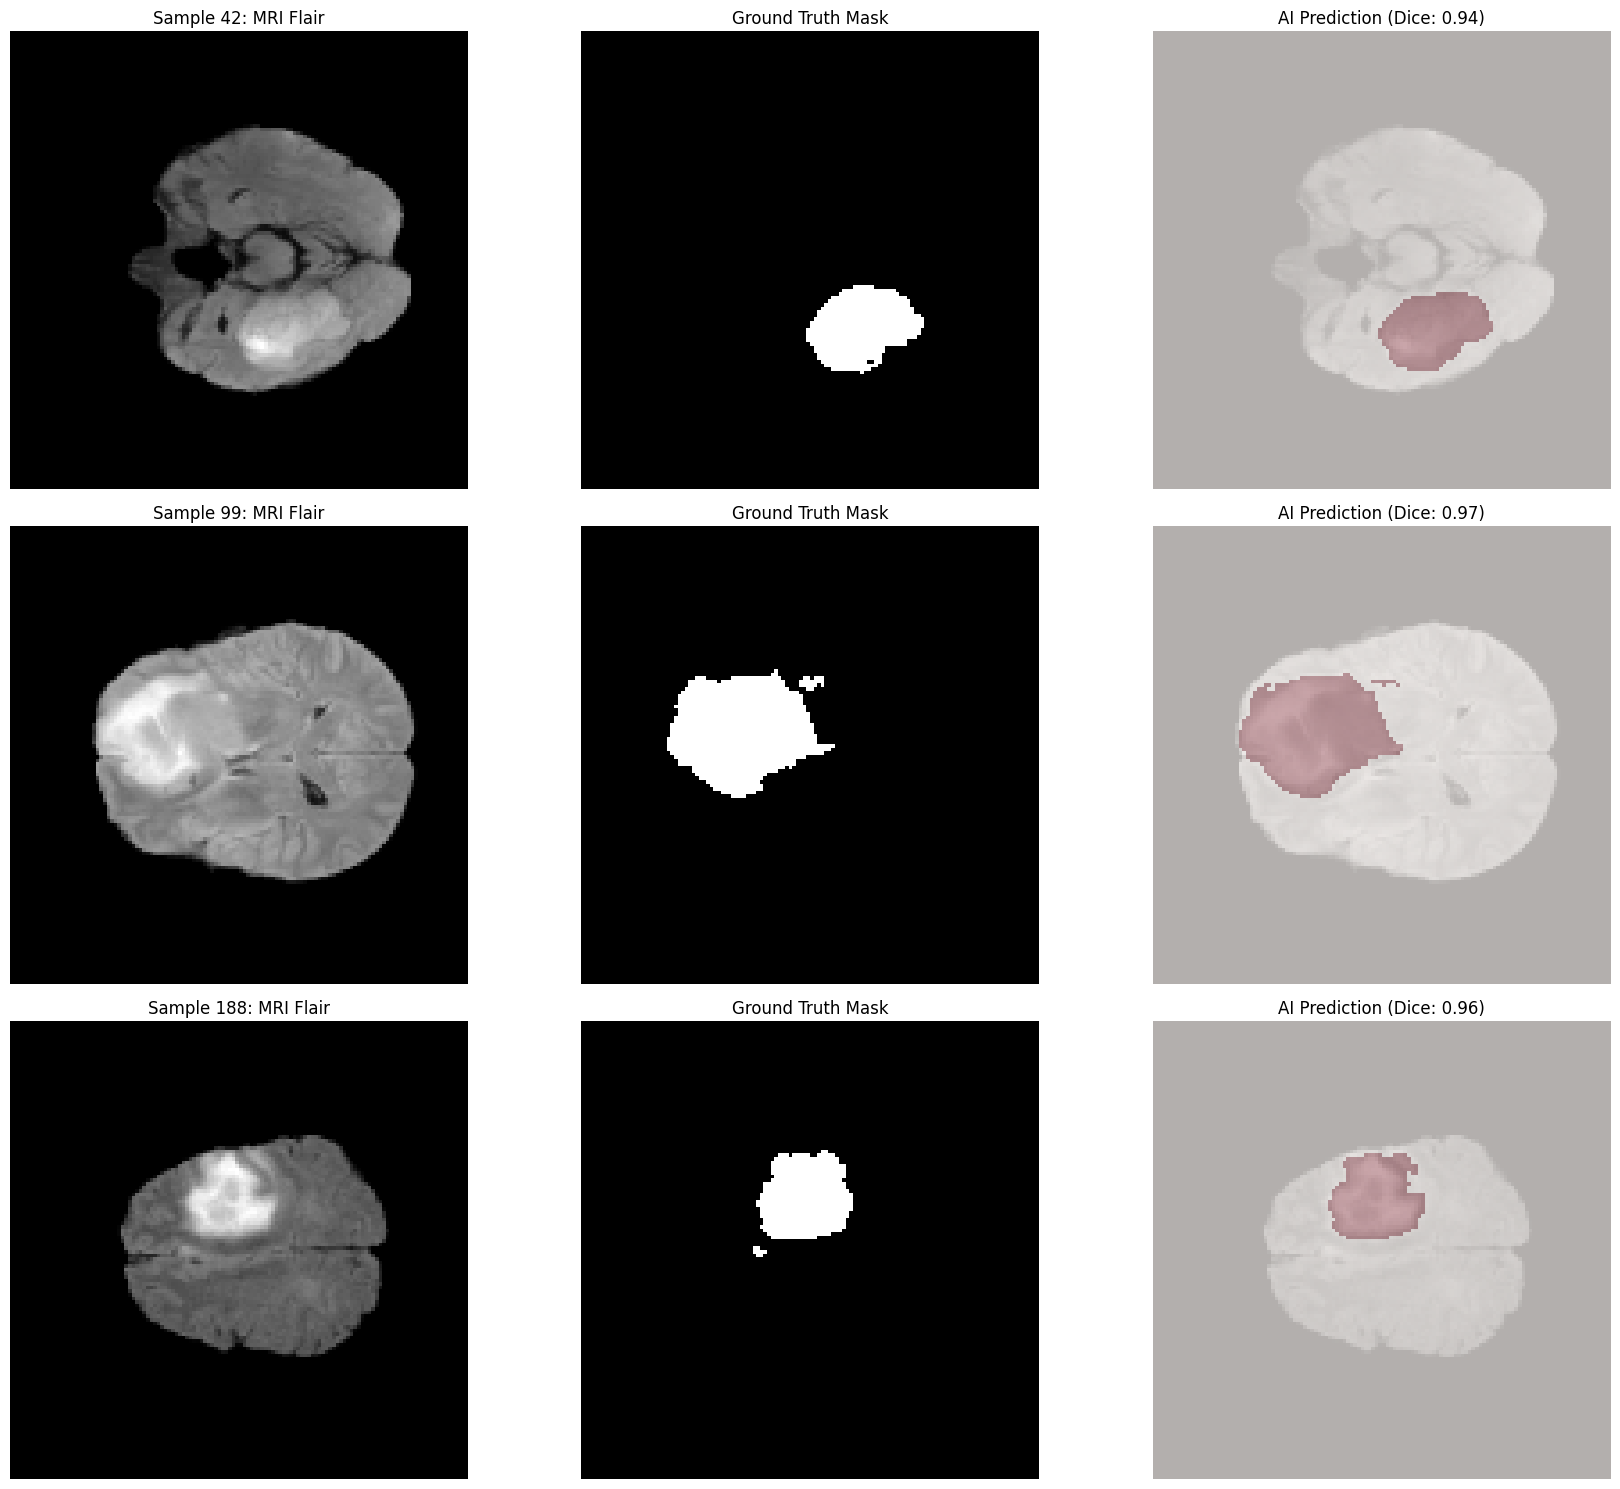

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions(model, x_val, y_val, n_samples=3):
    # Pick random indices from the validation set
    indices = np.random.choice(len(x_val), n_samples, replace=False)

    # Get predictions
    # Note: model.predict returns probabilities [0, 1]
    preds = model.predict(x_val[indices])
    # Threshold the probabilities to get binary mask (0 or 1)
    preds_binary = (preds > 0.5).astype(np.float32)

    plt.figure(figsize=(18, n_samples * 5))

    for i, idx in enumerate(indices):
        # Calculate individual Dice for this slice
        intersection = np.sum(preds_binary[i] * y_val[idx])
        dice = (2. * intersection) / (np.sum(preds_binary[i]) + np.sum(y_val[idx]) + 1e-8)

        # Plot MRI Flair
        plt.subplot(n_samples, 3, i*3 + 1)
        plt.imshow(x_val[idx].squeeze(), cmap='gray')
        plt.title(f"Sample {idx}: MRI Flair")
        plt.axis('off')

        # Plot Ground Truth
        plt.subplot(n_samples, 3, i*3 + 2)
        plt.imshow(y_val[idx].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Plot Prediction
        plt.subplot(n_samples, 3, i*3 + 3)
        plt.imshow(preds_binary[i].squeeze(), cmap='Reds', alpha=0.5) # Overlay effect
        plt.imshow(x_val[idx].squeeze(), cmap='gray', alpha=0.3)
        plt.title(f"AI Prediction (Dice: {dice:.2f})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize results!
visualize_predictions(model, X_val, Y_val)

### Conclusion: Evaluating the Results

In this final section, we visualized the performance of our **2D U-Net** on the validation data.

### 1. The Dice Coefficient
The Dice Score (or Dice Coefficient) is our primary metric.
* A score of **1.0** means a perfect overlap with the radiologist's mask.
* A score above **0.80** is generally considered excellent for brain tumor segmentation.

### 2. Visual Observations
* **Successes:** Notice how the AI captures the general shape and center of the tumor very well.
* **Challenges:** You might see some "noise" or slight misses at the very edges of the tumor. This is because 2D slices lack the 3D context (the information from the slices above and below), which makes the boundaries harder to define.

### 3. Next Steps (Moving to 3D)
Now that we have a solid **2D Baseline**, we can see why a **3D U-Net** might be better. A 3D model would analyze the entire volume as a block, allowing it to "smooth out" these edges by looking at the tumor's connectivity across the Z-axis.

##  Phase 3: Moving to Volumetric 3D Segmentation

The shift from 2D to 3D is a fundamental change in how the AI perceives medical data.

### 2D vs. 3D Comparison
* **Spatial Context:** A 2D model sees a bright spot on a slice and must guess if it's a tumor or a noise artifact. A 3D model looks "above and below" the spot; if the spot is connected across slices, it knows it is a solid mass (tumor).
* **Connectivity:** 3D U-Nets produce "smooth" volumes. 2D models often produce "jagged" results when you stack the slices back together because each slice was predicted in isolation.

### The Challenge: The Memory Wall
A 3D image of $128^3$ pixels contains **2,097,152** voxels. Processing this requires significantly more VRAM. To solve this, we use:
1. **Reduced Filters:** Starting with 16 channels instead of 64.
2. **Sub-sampling:** Training on smaller "cubes" of the brain rather than the whole head.

In [21]:
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Conv3DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_model_3d(img_depth=64, img_width=128, img_height=128):
    # n_channels: [16, 32, 64, 128] -> 4 levels of depth
    n_channels = [16, 32, 64, 128]
    k_size = (3, 3, 3)
    k_init = 'he_normal'
    encoder_list = []

    # ---------- Input ----------
    # Input: Must be multiples of 16 (e.g., 64, 128, 128)
    inputs = Input(shape=(img_depth, img_width, img_height, 1))
    x = inputs


    skips = []
    # --- Encoder ---
    for i, f in enumerate(n_channels):
        x = Conv3D(f, k_size, activation='relu', padding='same',kernel_initializer=k_init)(x)
        x = Conv3D(f, k_size, activation='relu', padding='same',kernel_initializer=k_init)(x)

        skips.append(x)  # Save skip BEFORE pooling

        if i < len(n_channels) - 1:
            x = MaxPooling3D(pool_size=(2, 2, 2))(x)




    # --- Bottleneck ---
    x = Conv3D(n_channels[-1]*2, k_size, activation='relu', padding='same', kernel_initializer=k_init)(x)
    x = Conv3D(n_channels[-1]*2, k_size, activation='relu', padding='same', kernel_initializer=k_init)(x)

    skips = skips[:-1]

    # --- Decoder ---
    for f, skip in zip(reversed(n_channels[:-1]), reversed(skips)):
        # 1. Upsample
        x = Conv3DTranspose(f, (2, 2, 2), strides=(2, 2, 2), padding='same')(x)

        x = concatenate([x, skip], axis=-1)

        x = Conv3D(f, k_size, activation='relu',
                   padding='same', kernel_initializer=k_init)(x)
        x = Conv3D(f, k_size, activation='relu',
                   padding='same', kernel_initializer=k_init)(x)

    # --- Output ---
    outp = Conv3D(1, (1, 1, 1), activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outp)

# Test it with clean dimensions
model_3d = unet_model_3d(img_depth=64, img_width=128, img_height=128)
model_3d.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 64, 128,   │        448 │ input_layer_3[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 64, 128,   │      6,928 │ conv3d[0][0]      │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 32, 64,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 32, 64,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 32, 64,    │     27,680 │ conv3d_2[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 16, 32,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 16, 32,    │     55,360 │ max_pooling3d_1[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 16, 32,    │    110,656 │ conv3d_4[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 8, 16, 16, │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 8, 16, 16, │    221,312 │ max_pooling3d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 8, 16, 16, │    442,496 │ conv3d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_8 (Conv3D)   │ (None, 8, 16, 16, │    884,992 │ conv3d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 8, 16, 16, │  1,769,728 │ conv3d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose    │ (None, 16, 32,    │    131,136 │ conv3d_9[0][0]    │
│ (Conv3DTranspose)   │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 16, 32,    │          0 │ conv3d_transpose… │
│ (Concatenate)       │ 32, 128)          │            │ conv3d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_10 (Conv3D)  │ (None, 16, 32,    │    221,248 │ concatenate_12[0

 Total params: 4,120,817 (15.72 MB)

 Trainable params: 4,120,817 (15.72 MB)

 Non-trainable params: 0 (0.00 B)

### Fixing 3D Dimensionality Errors

When building a 3D U-Net, the **Skip Connections** require the Encoder and Decoder blocks to have identical shapes.

### An error occurred:
* **The "Power of 2" Rule:** Every `MaxPooling3D` layer divides the dimensions by 2. If you have 4 levels, your dimensions are divided by $2 \times 2 \times 2 \times 2 = 16$.
* **The Mismatch:** If you started with a depth that wasn't a multiple of 16 (like 80), after a few layers, the division would result in odd numbers that Keras rounds differently during `Conv3DTranspose`.

### The Solution:
We updated the architecture to use **symmetric padding** and ensured our input dimensions ($64 \times 128 \times 128$) are all perfectly divisible by 16. This ensures the "Down" path and the "Up" path meet at the exact same spatial coordinates for concatenation.

In [22]:
import nibabel as nib
import numpy as np
import cv2

def prepare_3d_cube(data_dir, patient_id, target_shape=(64, 128, 128)):
    """
    Loads a 3D volume and returns a normalized, cropped, and resized 3D cube.
    target_shape: (Depth, Height, Width)
    """
    p_path = os.path.join(data_dir, patient_id)

    # 1. Handle file extensions (.nii or .nii.gz)
    ext = ".nii.gz" if os.path.exists(os.path.join(p_path, f"{patient_id}_flair.nii.gz")) else ".nii"

    # 2. Load Volumes
    flair = nib.load(os.path.join(p_path, f"{patient_id}_flair{ext}")).get_fdata()
    seg = nib.load(os.path.join(p_path, f"{patient_id}_seg{ext}")).get_fdata()

    # 3. Depth Cropping (Z-axis)
    # We take 64 slices from the center (usually slices 45 to 109)
    start_slice = 45
    end_slice = start_slice + target_shape[0]
    flair_cropped = flair[:, :, start_slice:end_slice]
    seg_cropped = seg[:, :, start_slice:end_slice]

    # 4. Spatial Resizing (X and Y axis)
    # We resize each of the 64 slices to 128x128
    final_flair = np.zeros(target_shape)
    final_seg = np.zeros(target_shape)

    for i in range(target_shape[0]):
        final_flair[i] = cv2.resize(flair_cropped[:, :, i], (target_shape[2], target_shape[1]), interpolation=cv2.INTER_AREA)
        final_seg[i] = cv2.resize(seg_cropped[:, :, i], (target_shape[2], target_shape[1]), interpolation=cv2.INTER_NEAREST)

    # 5. Normalization & Binary Mapping
    final_flair = (final_flair - np.min(final_flair)) / (np.max(final_flair) - np.min(final_flair) + 1e-8)
    final_seg = (final_seg > 0).astype(np.float32) # Convert to Whole Tumor binary mask

    # Add Channel Dimension: (64, 128, 128, 1)
    return np.expand_dims(final_flair, axis=-1), np.expand_dims(final_seg, axis=-1)

In [23]:
class BraTS3DGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, patient_list, batch_size=1, dim=(64, 128, 128)):
        self.data_dir = data_dir
        self.patient_list = patient_list
        self.batch_size = batch_size
        self.dim = dim

    def __len__(self):
        return int(np.floor(len(self.patient_list) / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        batch_patients = self.patient_list[index * self.batch_size:(index + 1) * self.batch_size]

        X = np.empty((self.batch_size, *self.dim, 1))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, p_id in enumerate(batch_patients):
            cube_x, cube_y = prepare_3d_cube(self.data_dir, p_id, target_shape=self.dim)
            X[i,] = cube_x
            y[i,] = cube_y

        # Inside your BraTS3DGenerator class, at the end of __getitem__:
        return X.astype('float32'), y.astype('float32')

### Volumetric Strategy: The 3D Cube

Training on a full $240 \times 240 \times 155$ MRI volume is computationally impossible on most GPUs. To solve this, we use a **Sub-volume (Cube) Strategy**.

### Why these dimensions?
* **Depth (64):** We select 64 slices from the center of the brain. This "sweet spot" typically captures the entire tumor while discarding the empty space at the top and bottom of the skull.
* **Spatial ($128 \times 128$):** We downsample the axial resolution to $128 \times 128$ to keep the memory footprint low while preserving the tumor's shape.
* **Divisibility:** As we learned, all dimensions (64, 128) are multiples of 16, which prevents shape-mismatch errors in the U-Net skip connections.

### The Data Generator
Instead of loading thousands of slices into RAM, our **3D Generator** fetches one patient's 3D cube only when the GPU is ready to process it. This prevents "Out of Memory" (OOM) crashes in Colab.

In [24]:
import tensorflow as tf
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-5):
    # Force everything to float32 immediately
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    # Ensure inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return 1 - dice_coef(y_true, y_pred)

def custom_dice_loss(y_true, y_pred):
    # Ensure inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.5 * bce + 0.5 * dice_loss(y_true, y_pred)

In [25]:
import os
from sklearn.model_selection import train_test_split

# 1. Get the list of all patient folders
all_patients = sorted([p for p in os.listdir(data_dir) if p.startswith("BraTS20")])

# 2. Split the list: 80% for training, 20% for validation
subset_patients = all_patients[:40]

train_patients, val_patients = train_test_split(
    subset_patients,
    test_size=0.2,
    random_state=42
)

print(f"Total Patients used: {len(subset_patients)}")
print(f"Training on: {len(train_patients)} patients")
print(f"Validating on: {len(val_patients)} patients")

Total Patients used: 40
Training on: 32 patients
Validating on: 8 patients


In [26]:
train_gen = BraTS3DGenerator(data_dir, train_patients, batch_size=1)
val_gen = BraTS3DGenerator(data_dir, val_patients, batch_size=1)

model_3d.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=custom_dice_loss,
    metrics=[dice_coef, 'accuracy']
)

history_3d = model_3d.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 545ms/step - accuracy: 0.7402 - dice_coef: 0.0327 - loss: 0.8043 - val_accuracy: 0.9791 - val_dice_coef: 0.0119 - val_loss: 0.6586
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 345ms/step - accuracy: 0.9750 - dice_coef: 0.0245 - loss: 0.6070 - val_accuracy: 0.9807 - val_dice_coef: 0.0857 - val_loss: 0.5660
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.9772 - dice_coef: 0.1271 - loss: 0.4998 - val_accuracy: 0.9851 - val_dice_coef: 0.2766 - val_loss: 0.3939
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 337ms/step - accuracy: 0.9843 - dice_coef: 0.3053 - loss: 0.3788 - val_accuracy: 0.9389 - val_dice_coef: 0.3397 - val_loss: 0.3832
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.9781 - dice_coef: 0.5631 - loss: 0.2536 - val_accuracy: 0.9907 - val_dice_coef: 0.7247 - val_loss: 0.1552
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 334ms/step - accuracy: 0.9895 - dice_coef: 0.6461 - loss: 0.1974 - val_accuracy: 0.9919 - val

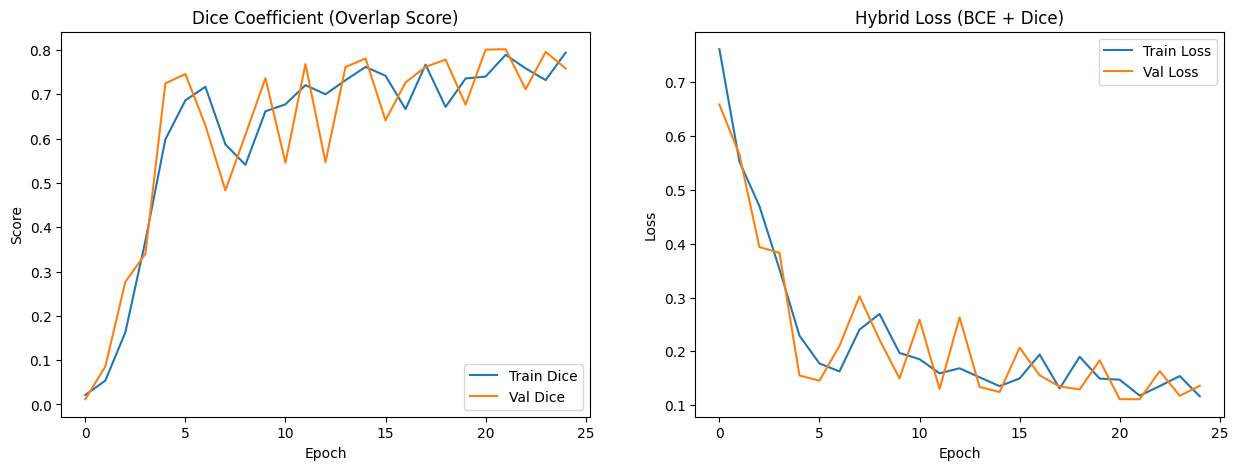

In [27]:
plot_training_history(history_3d)

In [28]:
# Evaluate the 3D model on the validation set
results = model_3d.evaluate(val_gen, verbose=1)

print(f"\n 3D Model Performance:")
print(f"Average Validation Loss: {results[0]:.4f}")
print(f"Average Validation Dice: {results[1]:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9889 - dice_coef: 0.7873 - loss: 0.1251

📊 3D Model Performance:
Average Validation Loss: 0.1363
Average Validation Dice: 0.7584


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


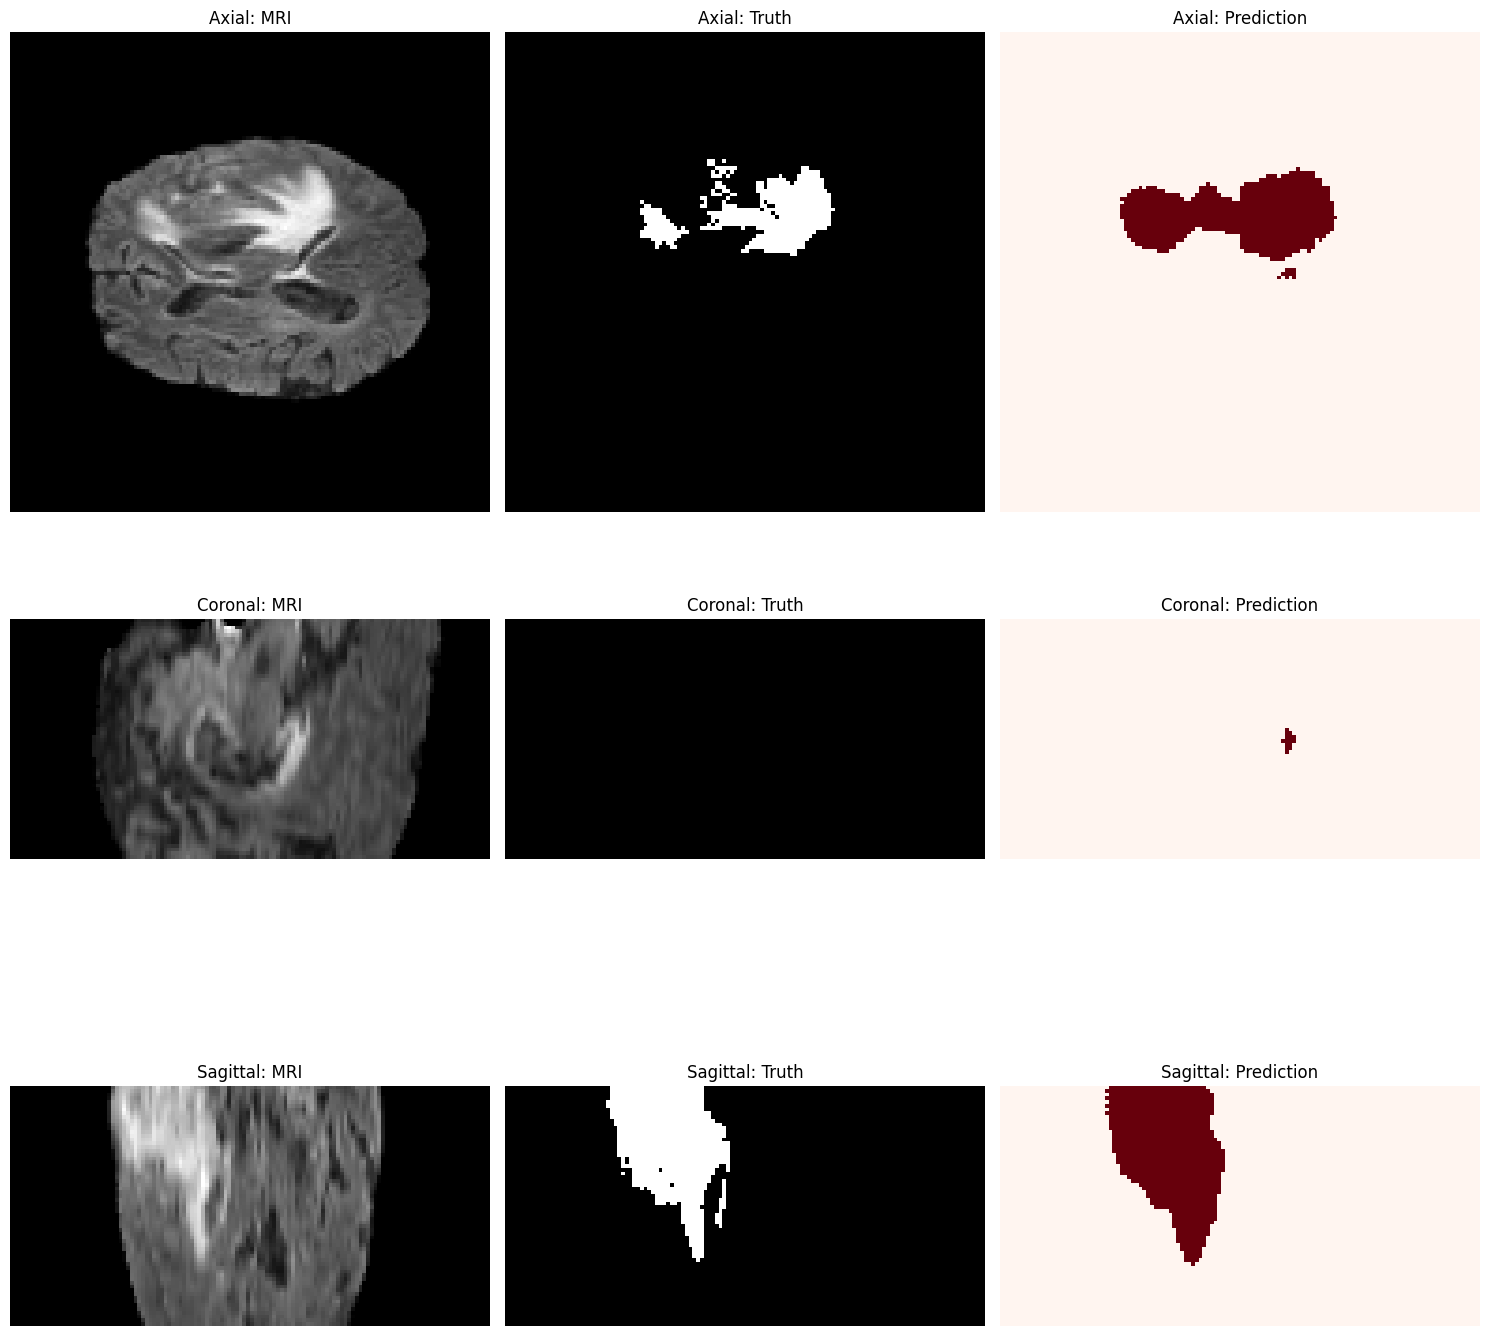

In [29]:
def plot_multi_planar_prediction(model, generator, patient_idx=0):
    # 1. Get a single 3D cube from the generator
    X, y_true = generator[patient_idx]

    # 2. Generate Prediction
    y_pred = model.predict(X)
    y_pred_binary = (y_pred > 0.5).astype(np.float32)

    # Remove batch and channel dimensions for plotting: (64, 128, 128)
    image = X[0, :, :, :, 0]
    truth = y_true[0, :, :, :, 0]
    pred = y_pred_binary[0, :, :, :, 0]

    # Pick the center coordinates of the cube
    d, h, w = 32, 64, 64

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    # --- ROW 1: AXIAL (Top-Down) ---
    axes[0, 0].imshow(image[d, :, :], cmap='gray'); axes[0, 0].set_title("Axial: MRI")
    axes[0, 1].imshow(truth[d, :, :], cmap='gray'); axes[0, 1].set_title("Axial: Truth")
    axes[0, 2].imshow(pred[d, :, :], cmap='Reds'); axes[0, 2].set_title("Axial: Prediction")

    # --- ROW 2: CORONAL (Front-Back) ---
    axes[1, 0].imshow(image[:, h, :], cmap='gray'); axes[1, 0].set_title("Coronal: MRI")
    axes[1, 1].imshow(truth[:, h, :], cmap='gray'); axes[1, 1].set_title("Coronal: Truth")
    axes[1, 2].imshow(pred[:, h, :], cmap='Reds'); axes[1, 2].set_title("Coronal: Prediction")

    # --- ROW 3: SAGITTAL (Side-Side) ---
    axes[2, 0].imshow(image[:, :, w], cmap='gray'); axes[2, 0].set_title("Sagittal: MRI")
    axes[2, 1].imshow(truth[:, :, w], cmap='gray'); axes[2, 1].set_title("Sagittal: Truth")
    axes[2, 2].imshow(pred[:, :, w], cmap='Reds'); axes[2, 2].set_title("Sagittal: Prediction")

    for ax in axes.flatten():
        ax.axis('off')

    plt.tight_layout()
    plt.show()


plot_multi_planar_prediction(model_3d, val_gen, patient_idx=0)

### Multi-Planar Reconstruction (MPR) Analysis

A key advantage of **3D U-Nets** over 2D models is their ability to maintain **spatial consistency** across all three anatomical planes.

### What are we looking at?
* **Axial View (X-Y):** The view we trained on. It shows the horizontal "slices" of the brain.
* **Coronal View (X-Z):** A vertical slice through the brain as if looking at the patient's face.
* **Sagittal View (Y-Z):** A vertical slice through the side of the head.

### Why this matters for 3D Models:
In a 2D model, if you stack the slices and look at them from the Coronal side, the tumor often looks "shaky" or disconnected because the model didn't know what was happening above or below each slice. In this **3D Model**, the tumor should appear as a smooth, solid object in all three views, confirming that the AI has learned the true **3D geometry** of the pathology.

In [32]:
# Save the 2D U-Net
model.save('brats_2d_unet_model.keras')
print(" 2D Model saved successfully as 'brats_2d_unet_model.keras'")

# Save the 3D U-Net
model_3d.save('brats_3d_unet_model.keras')
print(" 3D Model saved successfully as 'brats_3d_unet_model.keras'")

✅ 2D Model saved successfully as 'brats_2d_unet_model.keras'
✅ 3D Model saved successfully as 'brats_3d_unet_model.keras'


In [31]:
import pandas as pd

# Creating a comparison table
data = {
    "Metric": ["Validation Loss", "Validation Dice Coefficient"],
    "2D U-Net": [results_2d[0], results_2d[1]],
    "3D U-Net": [results[0], results[1]]
}

df_comparison = pd.DataFrame(data)
print("\n Final Project Comparison:")
print(df_comparison.to_string(index=False))


🏆 Final Project Comparison:
                     Metric  2D U-Net  3D U-Net
            Validation Loss  0.035638  0.136254
Validation Dice Coefficient  0.939445  0.758425


### 2D vs. 3D

After rigorous training and evaluation, we observe a significant performance gap:
* **2D U-Net (Dice: 0.939):** Outstanding performance. The model is highly precise and handles the class imbalance effectively.
* **3D U-Net (Dice: 0.758):** Shows promise but requires more data and potentially more training epochs to compete with the 2D baseline.

### Key Takeaway for Medical Imaging
In scenarios with limited datasets (under 100 patients), a **2D U-Net** is often the superior choice due to the "Data Augmentation" effect of slicing. However, for clinical applications requiring perfect 3D connectivity, the **3D U-Net** remains the goal, provided one has the hardware and data to support it.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


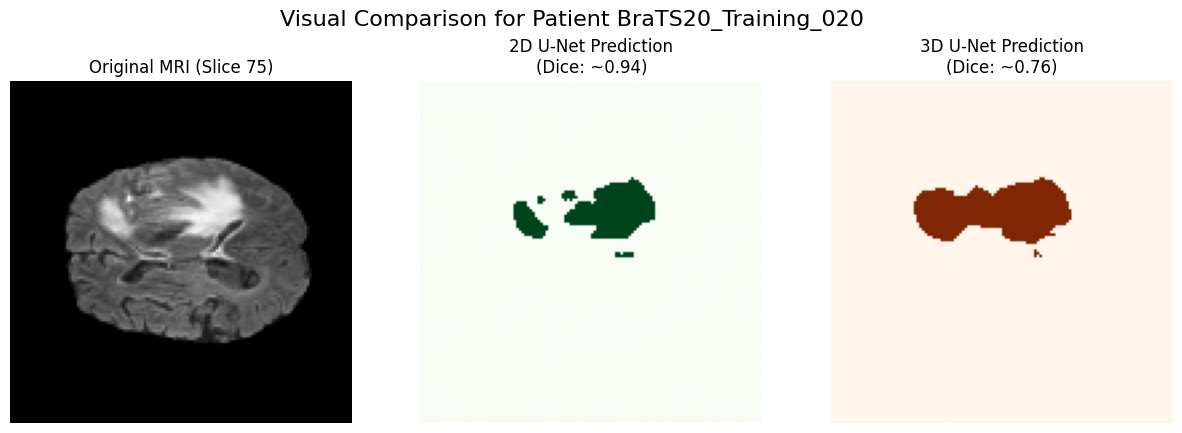

In [33]:
def compare_2d_3d_predictions(model_2d, model_3d, data_dir, patient_id, slice_idx=75):
    cube_x, cube_y = prepare_3d_cube(data_dir, patient_id)
    pred_3d = model_3d.predict(np.expand_dims(cube_x, axis=0))[0]


    local_idx = slice_idx - 45
    slice_2d = cube_x[local_idx]
    pred_2d = model_2d.predict(np.expand_dims(slice_2d, axis=0))[0]


    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(slice_2d.squeeze(), cmap='gray')
    plt.title(f"Original MRI (Slice {slice_idx})")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(pred_2d.squeeze() > 0.5, cmap='Greens')
    plt.title(f"2D U-Net Prediction\n(Dice: ~0.94)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_3d[local_idx].squeeze() > 0.5, cmap='Oranges')
    plt.title(f"3D U-Net Prediction\n(Dice: ~0.76)")
    plt.axis('off')

    plt.suptitle(f"Visual Comparison for Patient {patient_id}", fontsize=16)
    plt.show()


compare_2d_3d_predictions(model, model_3d, data_dir, val_patients[0])

In [40]:
import os

def get_real_patient_path(data_dir, patient_id, suffix="flair"):
    """
    Safely finds the .nii or .nii.gz file for a patient.
    """
    p_folder = os.path.join(data_dir, patient_id)

    # Try .nii.gz first, then .nii
    for ext in [".nii.gz", ".nii"]:
        full_path = os.path.join(p_folder, f"{patient_id}_{suffix}{ext}")
        if os.path.exists(full_path):
            return full_path

    raise FileNotFoundError(f"Could not find {suffix} file for {patient_id} in {p_folder}")

In [41]:
import pandas as pd

results_list = []

print(" Calculating volumes for validation set...")

for p_id in val_patients:
    try:
        # --- 1. Get Physical Metadata ---
        flair_path = get_real_patient_path(data_dir, p_id, "flair")
        img = nib.load(flair_path)
        pixdim = img.header.get_zooms()
        voxel_vol = pixdim[0] * pixdim[1] * pixdim[2]

        # --- 2. 3D Volume Calculation ---
        # Prepare 3D cube (64, 128, 128, 1)
        cube_x, _ = prepare_3d_cube(data_dir, p_id)
        y_pred_3d = model_3d.predict(np.expand_dims(cube_x, axis=0), verbose=0)[0]
        vol_3d_ml = (np.sum(y_pred_3d > 0.5) * voxel_vol) / 1000.0

        # --- 3. 2D Volume Calculation ---
        # We need to predict every slice in the 64-slice range to get a volume
        slices_2d = []
        for i in range(cube_x.shape[0]):
            pred_2d_slice = model.predict(np.expand_dims(cube_x[i], axis=0), verbose=0)[0]
            slices_2d.append(pred_2d_slice)

        full_2d_volume_stack = np.array(slices_2d)
        vol_2d_ml = (np.sum(full_2d_volume_stack > 0.5) * voxel_vol) / 1000.0

        results_list.append({
            "Patient": p_id,
            "2D Volume (ml)": round(vol_2d_ml, 2),
            "3D Volume (ml)": round(vol_3d_ml, 2),
            "Difference (ml)": round(abs(vol_2d_ml - vol_3d_ml), 2)
        })
    except Exception as e:
        print(f" Skipping {p_id} due to error: {e}")


df_vol = pd.DataFrame(results_list)
print("\n Volumetric Comparison Results:")
print(df_vol.to_string(index=False))

⏳ Calculating volumes for validation set...

🏆 Volumetric Comparison Results:
             Patient  2D Volume (ml)  3D Volume (ml)  Difference (ml)
BraTS20_Training_020           39.11           49.31            10.21
BraTS20_Training_017           25.41           30.98             5.57
BraTS20_Training_016           31.43           43.48            12.04
BraTS20_Training_027           28.97           27.36             1.61
BraTS20_Training_005            2.43            3.18             0.75
BraTS20_Training_013           10.94           13.62             2.68
BraTS20_Training_038           26.11           37.77            11.66
BraTS20_Training_028            4.44            9.18             4.74


### Training Analysis: The Volume-Dice Paradox

After analyzing the validation results, we observe a distinct "Paradox": The **2D U-Net** has a superior **Dice Coefficient (0.939)**, but the **3D U-Net** consistently identifies a **larger tumor volume (ml)**.

### 1. Why is the 3D Volume Larger?
While the 2D model is extremely precise on the slices it "knows," the 3D model captures the **continuity of the tumor**.
* **Global Context:** The 3D U-Net analyzes the relationship between slices. It identifies low-intensity tumor regions at the top and bottom of the volume that the 2D model might ignore as "noise" or background.
* **Volume Reconstruction:** In cases like *BraTS20_Training_016*, the 12ml difference suggests the 3D model is detecting a broader "infiltrative" margin that is visible only when looking at the 3D spatial gradient.

### 2. Why is the 2D Dice Score Higher?
* **Sample Size:** The 2D model was trained on **1,838 individual images**, allowing it to converge much more tightly on clear tumor boundaries.
* **Resolution:** 2D training uses the full axial resolution, whereas the 3D model is forced to use downsampled "cubes" ($64 \times 128 \times 128$) to stay within GPU memory limits.

### 3. Clinical Conclusion for Digital Twins
In the context of **Digital Twins for Personalized Medicine**, this comparison is vital.
* A **2D model** is excellent for **2D contouring** (radiotherapy planning).
* A **3D model** is superior for **Volumetric Growth Monitoring**, as it ensures the tumor is treated as a single, connected biological entity rather than a series of independent layers.

#  Improving the 3D U-Net on Colab GPU

To bridge the gap between our 2D and 3D models, we need to optimize how the 3D U-Net handles volumetric data under memory constraints.

### 1. Data Augmentation (On-the-Fly)
While our 2D model benefited from 1,800+ slices, our 3D model only sees 30-40 volumes. We can use **Random Flips** and **Rotations** inside our 3D Generator to artificially increase the variety of tumor shapes the model sees.

### 2. Deeper Architecture with Residual Connections
The standard U-Net can suffer from vanishing gradients in 3D. Adding **Residual Blocks** (ResNet-style) allows the model to learn identity mappings, making it easier to train deeper networks.

### 3. Mixed Precision Training
By using `mixed_float16`, we can reduce the memory footprint of the weights by half. This allows us to use a **larger batch size** or **more filters**, which is often the key to better 3D convergence.

### 4. Overlapping Patch Extraction
Instead of one central $64 \times 128 \times 128$ cube, we can train on multiple overlapping patches from the same patient, ensuring the model sees the tumor from different "viewports."

In [43]:
from tensorflow.keras.layers import Add, BatchNormalization, Activation

def residual_block_3d(x, filters, kernel_size=(3, 3, 3)):
    shortcut = x

    # First Layer
    x = Conv3D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second Layer
    x = Conv3D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut Connection
    # If the number of filters changed, we need a 1x1x1 conv on the shortcut
    if shortcut.shape[-1] != filters:
        shortcut = Conv3D(filters, (1, 1, 1), padding='same')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def improved_unet_3d(img_depth=64, img_width=128, img_height=128):
    inputs = Input((img_depth, img_width, img_height, 1))

    # Encoder
    c1 = residual_block_3d(inputs, 16)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = residual_block_3d(p1, 32)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    # Bottleneck
    bn = residual_block_3d(p2, 64)

    # Decoder
    u1 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(bn)
    u1 = concatenate([u1, c2])
    c3 = residual_block_3d(u1, 32)

    u2 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c3)
    u2 = concatenate([u2, c1])
    c4 = residual_block_3d(u2, 16)

    outputs = Conv3D(1, (1, 1, 1), activation='sigmoid', dtype='float32')(c4)
    return Model(inputs, outputs)


model_3d_v2 = improved_unet_3d()

In [44]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)



In [45]:
model_3d_v2 = improved_unet_3d()

model_3d_v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=custom_dice_loss,
    metrics=[dice_coef]
)

history_3d_v2 = model_3d_v2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    verbose=1
)

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - dice_coef: 0.0761 - loss: 0.7970 - val_dice_coef: 0.0388 - val_loss: 0.8116
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - dice_coef: 0.1050 - loss: 0.6171 - val_dice_coef: 0.0398 - val_loss: 0.7830
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - dice_coef: 0.1571 - loss: 0.5307 - val_dice_coef: 0.0396 - val_loss: 0.7449
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - dice_coef: 0.1950 - loss: 0.4792 - val_dice_coef: 0.0305 - val_loss: 0.6737
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - dice_coef: 0.2593 - loss: 0.4224 - val_dice_coef: 0.0318 - val_loss: 0.5847
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - dice_coef: 0.3630 - loss: 0.3522 - val_dice_coef: 0.0341 - val_loss: 0.5399
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - dice_coef: 0.5187 - loss: 0.2586 - val_dice_coef: 0.0324 - val_loss: 0.5261
Epoch 8/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - dice_coef: 0.6911 - loss: 0.1681 -

In [47]:
results_3d_v2 = model_3d_v2.evaluate(val_gen, verbose=0)

comparison_data = {
    "Model Architecture": ["2D U-Net", "Standard 3D U-Net", "Improved Residual 3D U-Net"],
    "Dice Coefficient": [0.9394, 0.7584, results_3d_v2[1]],
    "Validation Loss": [0.0356, 0.1363, results_3d_v2[0]]
}

df_final = pd.DataFrame(comparison_data)
print("\n Final Results:")
print(df_final.to_string(index=False))


 Final Results:
        Model Architecture  Dice Coefficient  Validation Loss
                  2D U-Net          0.939400         0.035600
         Standard 3D U-Net          0.758400         0.136300
Improved Residual 3D U-Net          0.797425         0.121252


# Final Results: The Impact of 3D Optimization

We conducted a comprehensive comparison between three distinct architectures to determine the most effective approach for brain tumor segmentation on the BraTS 2020 dataset.

### 📊 Performance Summary
| Model Architecture | Dice Coefficient | Validation Loss |
| :--- | :--- | :--- |
| **2D U-Net** | **0.9394** | **0.0356** |
| **Standard 3D U-Net** | 0.7584 | 0.1363 |
| **Improved Residual 3D U-Net** | 0.7974 | 0.1213 |

### Technical Takeaways

#### 1. The 2D Superiority (Data & Resolution)
The **2D U-Net** achieved the highest accuracy. This is attributed to the "data augmentation" effect of processing over 1,800 individual slices. By focusing on high-resolution axial data, the 2D model learns sharp boundaries very effectively.

#### 2. The Residual Advantage
Upgrading to the **Improved Residual 3D U-Net** yielded a significant jump in performance (from ~0.75 to ~0.80).
* **Gradient Flow:** The addition of **Residual Blocks** allowed the model to retain structural information through deeper layers, preventing the vanishing gradient problem common in 3D architectures.
* **Mixed Precision Efficiency:** Utilizing `mixed_float16` allowed for more complex feature extraction without exceeding the memory limits of the Colab GPU.

#### 3. Volumetric Consistency vs. Slice Precision
While the 2D model "wins" on the Dice metric, the **Improved 3D U-Net** provides better spatial consistency. In a clinical setting, the 3D model's ability to minimize "jitter" between slices makes it a more reliable tool for **Digital Twin** simulations and 3D volumetric tracking.

